### 5.1 Logistic Regression

In [1]:
import os
os.chdir('C:\Users\whwsky\Documents\GitHub\PHBS_TQFML\Project\Code')
current_path = os.getcwd()
data_path = os.path.dirname(os.getcwd()) + '/Data/'

import numpy as np
import pandas as pd
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

#### 5.1.1. Feature Preprocessing and choose of  hyperparameters
* We train on 70% of the sample and test on 30% of the sample
* SMOTE transformation is used to tackle the 'imbalance dataset' problem
* To increase training speed, the data are standardized
* We use pca to reduce dimension
* To determine the parameter C in logistic regression, we use the grid search.

In [3]:
stock_data = pd.read_csv(data_path + 'traindf.csv')
stock_data.head()

,Unnamed: 0,pchange,buy_rate_0,buy_rate_1,buy_rate_2,buy_rate_3,buy_rate_4,buy_rate_5,buy_rate_6,buy_rate_7,...,lag_3_sell_rate_3,lag_3_sell_rate_4,lag_3_sell_rate_5,lag_3_sell_rate_6,lag_3_sell_rate_7,lag_3_total_rate,lag_3_pchange,amplitude,above_mean,f_2_target
0,296977,0.000000,0.004262,0.039358,0.069322,0.101553,0.070741,0.085366,0.043228,0.731700,...,0.137638,0.113725,0.097507,0.051210,0.706770,0.774878,-0.006867,0.034513,0.0,0.0
1,296978,-0.000870,0.003005,0.036391,0.045658,0.087576,0.080052,0.058568,0.066485,0.697046,...,0.107572,0.084417,0.095497,0.041856,0.474385,1.066063,0.001745,0.018634,1.0,0.0
2,296979,-0.011374,0.003534,0.028775,0.042148,0.083343,0.050439,0.038310,0.022141,0.488783,...,0.099209,0.077372,0.065368,0.060073,0.579543,1.039132,-0.013865,0.017637,1.0,0.0
3,296980,0.000886,0.004373,0.042493,0.049465,0.079775,0.052786,0.050205,0.036913,0.386499,...,0.064352,0.064303,0.087575,0.048398,0.545517,1.145529,0.000000,0.030222,0.0,0.0
4,296981,-0.001778,0.005291,0.041583,0.121921,0.116330,0.137974,0.053226,0.056889,0.637819,...,0.068138,0.067701,0.046487,0.048684,0.618164,1.074781,-0.000870,0.014350,0.0,0.0


In [4]:
X_raw=stock_data.iloc[:,1:75].values
y_raw=stock_data.iloc[:,-1].values

X_train, X_test, y_train, y_test = train_test_split(
    X_raw, y_raw, test_size=0.3, random_state=1)

sm = SMOTE()
X_train, y_train = sm.fit_sample(X_train, y_train)

In [5]:
pipe_lr = make_pipeline(StandardScaler(),
                        PCA(n_components=0.99),
                        LogisticRegression(random_state=1))

param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]

param_grid = [{'logisticregression__C': param_range}]

gs = GridSearchCV(estimator=pipe_lr, 
                  param_grid=param_grid, 
                  scoring='precision', 
                  cv=10,
                  n_jobs=-1)
gs = gs.fit(X_train, y_train)
print(gs.best_params_)

{'logisticregression__C': 0.1}


The best C is 1.0. We will use this parameter to see the precison of test data and ROC curve.

#### 5.1.2. Logistic Regression

In [7]:
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)
pca = PCA(n_components=0.99)
X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.transform(X_test_std)
lr = LogisticRegression(C=0.1, random_state=1)
lr.fit(X_train_pca, y_train)
y_pred = lr.predict(X_test_pca)
print('Precision: %.2f' % precision_score(y_true=y_test, y_pred=y_pred))

Precision: 0.37


The precision is realtively low, which means logistic model doesn't have great ability to predict.

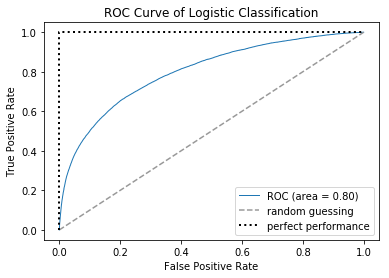

In [8]:
y_probas = lr.predict_proba(X_test_pca)
fpr, tpr, thresholds = roc_curve(y_test, y_probas[:,1], pos_label = 1)
roc_auc = auc(fpr, tpr)
plt.plot(fpr,tpr,lw =1, label = 'ROC (area = %.2f)' %(roc_auc))
plt.plot([0,1], [0,1], linestyle = '--', color = (0.6, 0.6, 0.6), label = 'random guessing')
plt.plot([0,0,1], [0,1,1], lw=2, linestyle = ':', color = 'black', label = 'perfect performance')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve of Logistic Classification')
plt.legend(loc = 'lower right')

The area under curve is 0.80.